In [99]:
import pandas as pd
import numpy as np
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt


In [100]:
K = 4000
import pickle
with open(f'clusters-{K//1000}K.pkl', 'rb') as f:
    clusters = pickle.load(f)

In [101]:
C = clusters['X']
C = np.stack(C)
Cangles = np.array([clusters['phi0'], clusters['psi0'], clusters['phi1'], clusters['psi1']]).T

In [107]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors().fit(C.reshape(C.shape[0], -1))
#indices = neight.kneighbors(C.reshape(C.shape[0], -1), n_neighbors=1, return_distance=False)

In [108]:
with open(f'labels-{K//1000}K.pkl', 'rb') as f:
    clust_labels = pickle.load(f)

In [109]:
def read_trajectory(traj, atoms={'N','CA','C','O'}):
    
    df = pd.read_table(
        traj, 
        delim_whitespace=True, header=None, 
        names=['code', 'atom_id', 'atom', 'name', 'res_id', 'x', 'y', 'z', 'occupancy', '_', 'element']
    )
    df = df.query('code=="ATOM" and atom in @atoms').astype(
        {'atom_id': np.int64, 'x': float, 'y': float, 'z': float, 'occupancy': float, 'res_id': int}
    )

    n_atoms = len(set(df['atom_id']))
    assert len(df) % n_atoms == 0

    df['frame_id'] = [x // n_atoms for x in range(0, len(df))]

    return df

def get_coordinates(traj, atoms={'N','CA','C','O'}):    
    residues = {
        row['res_id']: row['name']
        for _, row in traj[['res_id', 'name']].drop_duplicates().iterrows()
    }
    n_atoms = len(atoms)
    sub_traj = traj.query('atom in @atoms').sort_values(['frame_id', 'res_id', 'atom_id'])
    atom_count = sub_traj.query('frame_id==0').groupby('res_id')['atom'].count().to_dict()
    valid_res = set(k for k, n in atom_count.items() if n == n_atoms)
    sub_traj = sub_traj.query('res_id in @valid_res')
    n_frames = len(set(sub_traj['frame_id']))
    n_residues = len(sub_traj) // n_frames // n_atoms
    X = sub_traj[['x','y','z']].values.reshape([n_atoms, n_residues, n_frames, 3], order='F').transpose([2,1,0,3])
    residues = {k: residues[k] for k in sorted(valid_res)}
    return X, residues

In [110]:
import numba

@numba.njit(parallel=True)
def canonize(X: np.ndarray):
    #X = np.vstack(coords)
    X = X - X[2,:]
    
    e1 = X[4,:]-X[2,:]
    e1 = e1/np.linalg.norm(e1)
    
    e3 = np.cross(X[2,:]-X[4,:], X[5,:]-X[4,:])
    e3 = e3/np.linalg.norm(e3)
    
    e2 = np.cross(e3, e1)
    e2 = e2/np.linalg.norm(e2)
    
    U = np.zeros((3,3))
    U[:,0] = e1
    U[:,1] = e2
    U[:,2] = e3    
    #U = np.vstack([e1, e2, e3]).T

    X = X @ U
    return X
    
@numba.jit
def clusterize(C, xcan):
    d = np.sqrt(((xcan[None,:,:]-C)**2).sum(2).mean(1))
    i = np.argmin(d)
    return i, d[i]

def clusterize_fast(neigh, xcan):
    d, i = neigh.kneighbors(xcan.reshape(xcan.shape[0], -1), n_neighbors=1, return_distance=True)
    return i[:,0], d[:,0]

In [111]:
def canonize_batch(X: np.ndarray):
    #X = np.vstack(coords)
    X = X - X[:,2,:][:,None,:]
    
    e1 = X[:,4,:]-X[:,2,:]
    e1 = e1/np.linalg.norm(e1, axis=1)[:,None]
    
    e3 = np.cross(X[:,2,:]-X[:,4,:], X[:,5,:]-X[:,4,:], axis=1)
    e3 = e3/np.linalg.norm(e3, axis=1)[:,None]
    
    e2 = np.cross(e3, e1, axis=1)
    e2 = e2/np.linalg.norm(e2, axis=1)[:,None]
    
    U = np.stack([e1, e2, e3], axis=2)
    return np.einsum('nij,njk->nik', X, U) #X

In [150]:
def clusterize_traj(coords, residues):
    import multiprocessing as mp
    from process import canonize

    inputs = []
    indices = []
    res_ids = list(residues.keys())
    pairs = [res for res in range(coords.shape[1]-1) if res_ids[res+1] == res_ids[res]+1]
    for frame in range(coords.shape[0]):
        for pair, res in enumerate(pairs):
            x = coords[frame,res:res+2,:]
            inputs.append(x)
            indices.append((frame, res, pair))

    labels = np.zeros((coords.shape[0], len(pairs), 2))
    with mp.Pool(mp.cpu_count(),) as pool:
        for k, (xcan, (frame, res, pair)) in enumerate(zip(pool.imap(canonize, inputs, chunksize=100), indices)):
            idx, d = clusterize(C, xcan)
            labels[frame, pair, :] = [idx, d]
    return labels, pairs


def clusterize_traj_fast(coords, residues):    
    inputs = []
    indices = []
    res_ids = sorted(residues.keys())
    pairs = [res for res in range(coords.shape[1]-1) if res_ids[res+1] == res_ids[res]+1]
    for frame in range(coords.shape[0]):
        for pair, res in enumerate(pairs):
            x = coords[frame,res:res+2,:]
            inputs.append(np.vstack(x))
            indices.append((frame, res, pair))
    inputs = np.stack(inputs, axis=0)
            
    xcan = canonize_batch(inputs)        
    xcan = np.stack(xcan)
    idxs, dists = clusterize_fast(neigh, xcan)
    
    labels = np.zeros((coords.shape[0], len(pairs), 2))
    for i, d, (frame, res, pair) in zip(idxs, dists, indices):
        labels[frame, pair, :] = [i, d]
        
    return labels, pairs

In [78]:
def temporal_rms(labels, C):
    rms = []
    for pair in range(labels.shape[1]):
        idx = [int(i) for i in sorted(set(labels[:,pair,0]))]
        rms.append(np.sqrt(C[idx,:].reshape(len(idx), -1).var(0).sum()))
    return np.array(rms)

In [180]:
TRAJECTORIES = {}
TRMS = {}

In [10]:
with open(f'probs-{K//1000}K.pkl', 'rb') as f:
    data = pickle.load(f)
TRAJECTORIES = data['TRAJECTORIES']
P = data['P']

In [181]:
MD_DATA_DIR = Path('./atlas_data_small/')

atoms={'N','CA','C','O'}

keys = []
for k, xvg in enumerate(sorted(glob(str(MD_DATA_DIR / '*.pkl')))):
    key = Path(xvg).parts[-1]
    if key in TRAJECTORIES:
        continue
    keys.append((key, xvg))

In [182]:
keys = sorted(keys)

In [194]:
for k, (key, xvg) in enumerate(keys):
    try:
        #key = Path(xvg).parts[-1]
        #if key in TRAJECTORIES:
        #    continue
        #traj = read_trajectory(xvg, atoms=atoms)
        #coords, residues = get_coordinates(traj, atoms=atoms)
        with open(xvg, 'rb') as f:
            residues, coords, angles = pickle.load(f)
        coords = coords[:,1:-1,:,:] * 10 # from nm to A
        residues = {
            idx: val
            for idx, val in zip(residues.index, residues['AA'])
        }
        labels, pairs = clusterize_traj_fast(coords, residues)
        trms = temporal_rms(labels, C)
        TRAJECTORIES[key] = labels
        TRMS[key] = trms
        print(f"{k}\t{key:30s}\t{len(residues)}\ttrms={trms.mean():.2f}")
    except Exception:
        print(f"{k}\t{key:30s}\tError")

0	1ail_A_processed_R1.pkl       	71	trms=0.94
1	1dtd_B_processed_R1.pkl       	59	trms=1.35
2	1gqe_A_processed_R1.pkl       	363	trms=1.10
3	1j8e_A_processed_R1.pkl       	42	trms=1.89
4	1j8r_A_processed_R1.pkl       	194	trms=1.23
5	1jif_A_processed_R1.pkl       	120	trms=1.32
6	1jo0_A_processed_R1.pkl       	96	trms=1.19
7	1jyo_B_processed_R1.pkl       	128	trms=1.15
8	1m5q_I_processed_R1.pkl       	128	trms=1.22
9	1m8s_A_processed_R1.pkl       	122	trms=1.17
10	1q2h_A_processed_R1.pkl       	67	trms=1.11
11	1qau_A_processed_R1.pkl       	110	trms=1.21
12	1r8m_E_processed_R1.pkl       	201	trms=0.94
13	1rlk_A_processed_R1.pkl       	115	trms=0.98
14	1t9i_B_processed_R1.pkl       	161	trms=1.04
15	1tgr_A_processed_R1.pkl       	50	trms=1.18
16	1u55_A_processed_R1.pkl       	186	trms=1.05
17	1upt_D_processed_R1.pkl       	58	trms=0.91
18	1v7r_A_processed_R1.pkl       	184	trms=1.11
19	1wui_S_processed_R1.pkl       	265	trms=1.19
20	1xvg_E_processed_R1.pkl       	168	trms=0.99
21	1y0n_A

In [195]:
P = np.zeros((C.shape[0], C.shape[0]))
for traj in TRAJECTORIES.values():
    for i, j in zip(traj[0:-1,:,0].reshape(-1), traj[1:,:,0].reshape(-1)):
        P[int(i),int(j)] += 1/(traj.shape[0]-1)

In [199]:
from numpy import linalg as la

def hitting_times(T, max_iter = 10000):
    one = np.ones(T.shape) - np.eye(T.shape[0])
    k = np.zeros(T.shape[0])
    for i in range(max_iter):
        if i % 1000 == 0:
            print(i)
        k_old = k
        k = one + T.dot(k)
        k -= np.diag(np.diag(k))
        if la.norm(k-k_old) < 1e-6:
            break
    return k

In [200]:
time_step = 0.01 # ns = 10ps
p = P.sum(1)
idx_nonzero = (p>0) & (P.sum(0) > 0)
Pnrm = P[idx_nonzero,:][:,idx_nonzero] / p[idx_nonzero][:,None]
Cnrm = C[idx_nonzero,:]
Cangles_nrm = Cangles[idx_nonzero,:]

In [201]:
label_lut = {}
count = 0
for l, idx in enumerate(idx_nonzero):
    if idx:
        count += 1
        label_lut[l] = count-1
    else:
        label_lut[l] = -1

In [202]:
all_labels = np.array([label_lut[l] for l in clust_labels['labels']])
idx_valid = (all_labels >= 0)
all_labels = all_labels[idx_valid]
all_angles = clust_labels['angles'][idx_valid,:]

In [203]:
with open(f'atlas-probs-{K//1000}K.pkl', 'wb') as f:
    pickle.dump({
        'P': P,
        'TRAJECTORIES': TRAJECTORIES,
    }, f)

In [204]:
time_step

0.01

/var/folders/66/tn5rx60n69j6lxhny08gdcgh0000gn/T/ipykernel_56325/2097098694.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(Pnrm[0:10,0:10]))


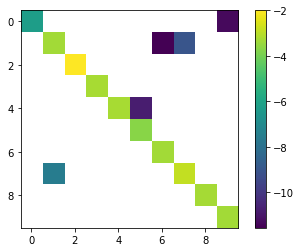

In [205]:
plt.imshow(np.log(Pnrm[0:10,0:10]))
plt.colorbar()

In [206]:
H = hitting_times(Pnrm, max_iter = 10000) * time_step

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


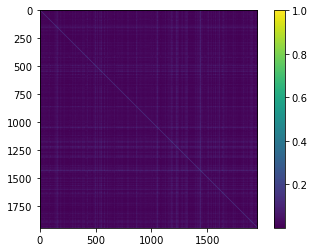

In [214]:
t = 5
plt.imshow(np.exp(-np.minimum(H,H.T)/t))
plt.colorbar()
#ticks = np.array(list(range(0,1000)))
#plt.xticks(ticks, ticks)
#plt.yticks(ticks, ticks)
print()

In [238]:
from sklearn.cluster import SpectralClustering

t = 5
A = np.exp(-np.minimum(H,H.T)/t)
k = 10
clustering = SpectralClustering(
    n_clusters=k,
    assign_labels='discretize',
    affinity="precomputed",
    random_state=0
).fit(A)

In [239]:
import seaborn as sns
colors = list(sns.color_palette('tab20'))

In [240]:
sns.color_palette('tab20')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [244]:
import sys
sys.path.append('/Users/alexbron/proteins/proteins/src')
from pp5.distributions.kde import kde_2d, torus_gaussian_kernel_2d
from functools import partial

def _level_th(p, level):
    """
    Calculates level set threshold in an image.
    """
    pp = sorted(p.reshape(-1))
    cc = np.cumsum(pp)
    icut = (np.argwhere(cc<=-level)[-1] if level < 0 else np.argwhere(cc>=level)[0])[0]
    pcut = pp[icut]
    return pcut


def _level_image(p, level):
    """
    Calculates level image.
    """
    pcut = _level_th(p, level)
    return p >= pcut

def contour(
    angles,
    level = 0.1,
    bin_width = 2.*np.pi/180.,
    sigma = 12.*np.pi/180.,
    col='r',
    alphain=0.1,
    alphaout=0.8,
    hatch=None,
):
    
    kernel_fn = partial(torus_gaussian_kernel_2d, sigma=sigma)
    
    min_angle = [-2*np.pi, -2*np.pi]
    max_angle = [+2*np.pi, +2*np.pi]
    n_bins = [
        int(np.round((mx - mn) / bin_width)) for mn, mx in zip(min_angle, max_angle)
    ]
    n_bins = max(n_bins)
    
    F = kde_2d(
        angles[:, 0],
        angles[:, 1],
        kernel_fn,
        n_bins,
        min_angle[0],
        max_angle[0],
        batch_size=1000,
    )
    grids = [
        np.linspace(amin, amax - (amax-amin) / n_bins, n_bins)
        for amin, amax in zip(min_angle, max_angle)
    ]
    
    #plt.imshow(F.T, extent=np.array((min_angle[0], max_angle[0], min_angle[1], max_angle[1]))*180./np.pi, origin='lower')
    #plt.colorbar()
    th = _level_th(F, level)
    cs = plt.contourf(*np.meshgrid(grids[0]*180/np.pi, grids[1]*180/np.pi), F.T, levels=[th,F.max()+0.1], colors=[col], alpha=alphain, hatches=[hatch])
    plt.contour(*np.meshgrid(grids[0]*180/np.pi, grids[1]*180/np.pi), F.T, levels=[th], colors=[col], alpha=alphaout)
    
    for collection in cs.collections:
        collection.set_edgecolor((*col, alphaout))
        collection.set_linewidth(0.)

    plt.xlim([-180,180])
    plt.ylim([-180,180])


In [245]:
labels = clustering.labels_
sizes = np.array([
    (labels==l).sum() for l in range(k)
])
sortorder = np.argsort(-sizes) 

0	0	706	15000
1	9	425	15000
2	1	384	15000
3	2	239	15000
4	7	79	15000
5	5	76	15000
6	8	17	3438
7	4	10	1883
8	6	6	149
9	3	5	85


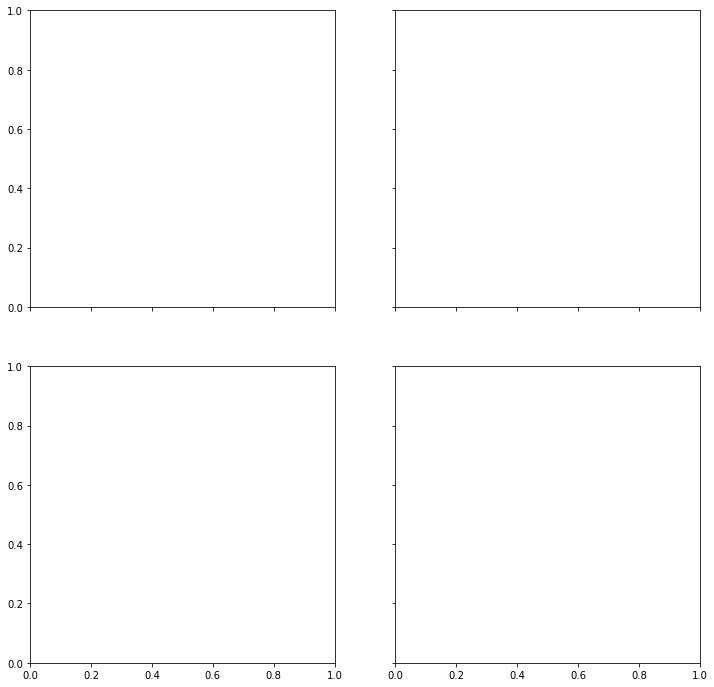

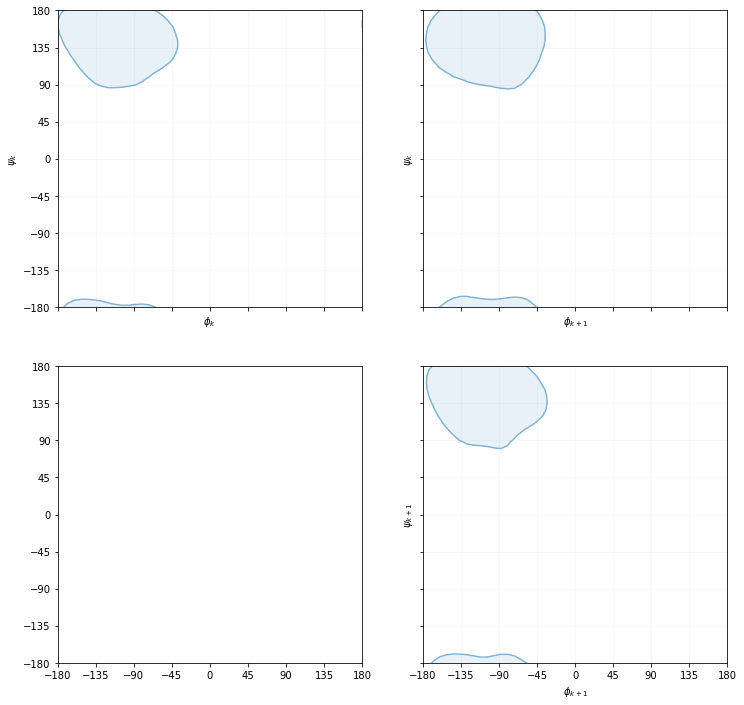

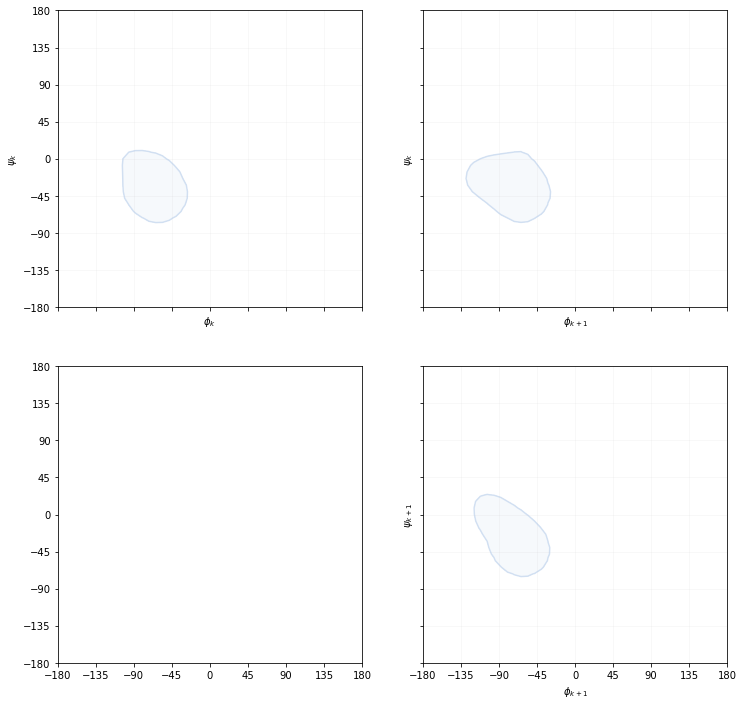

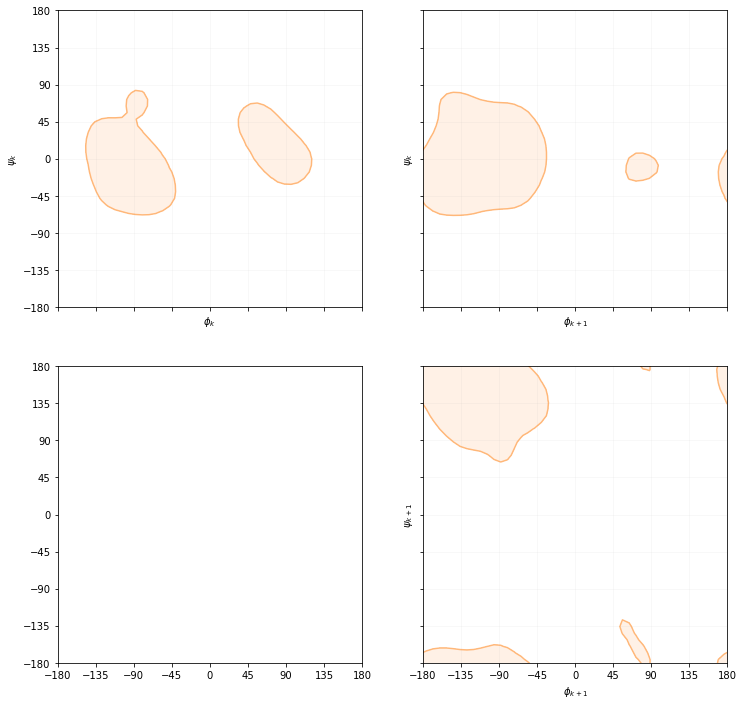

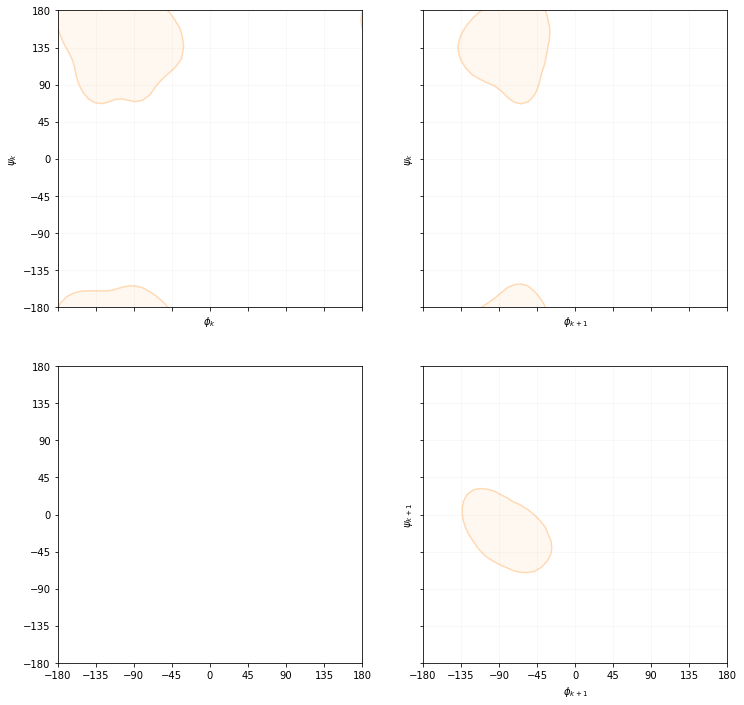

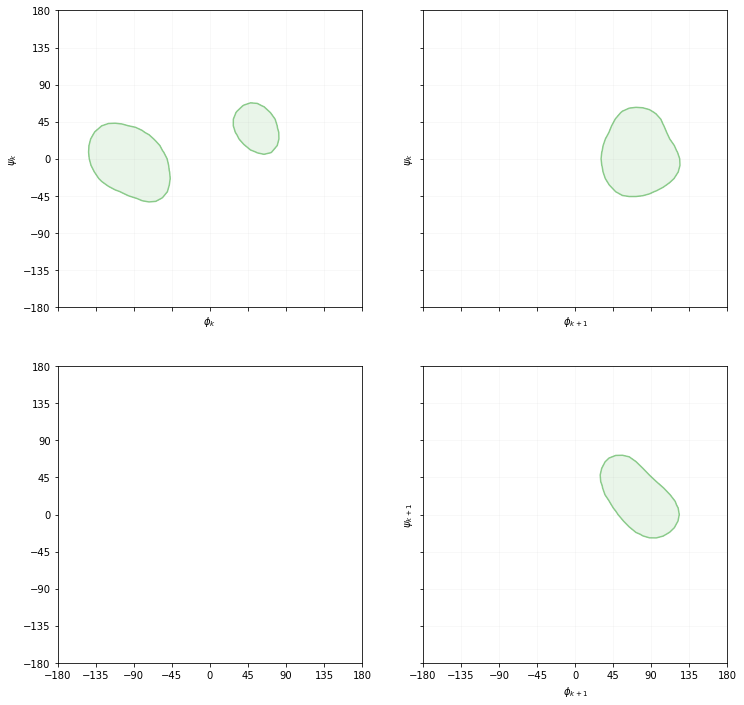

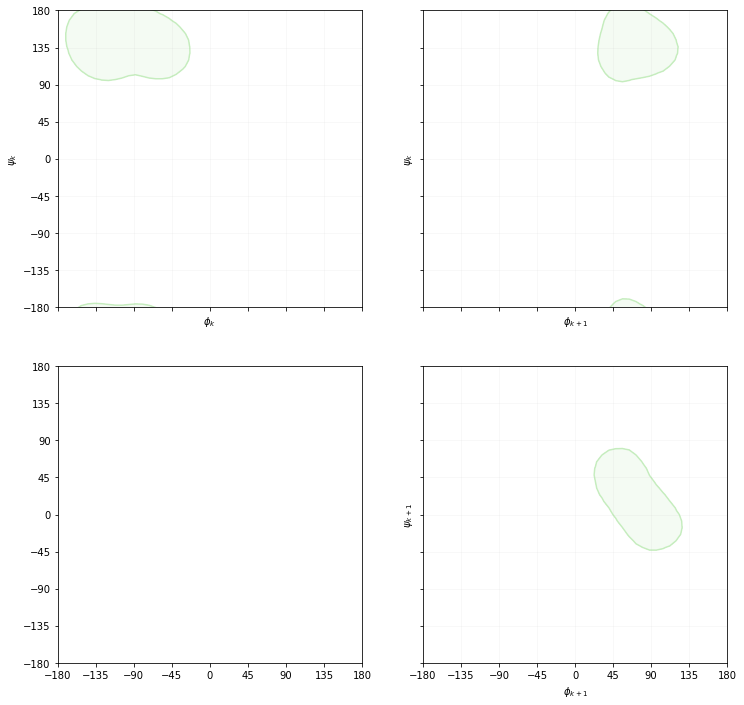

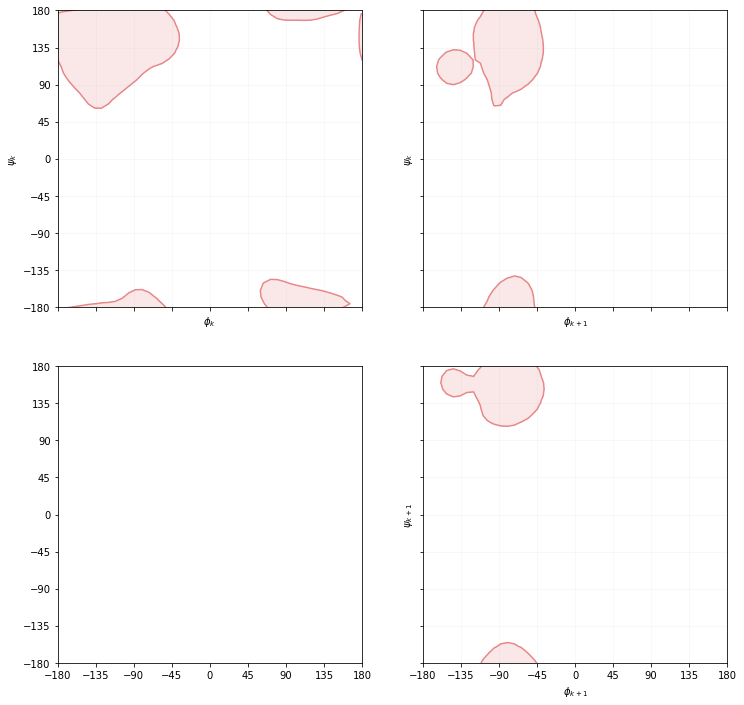

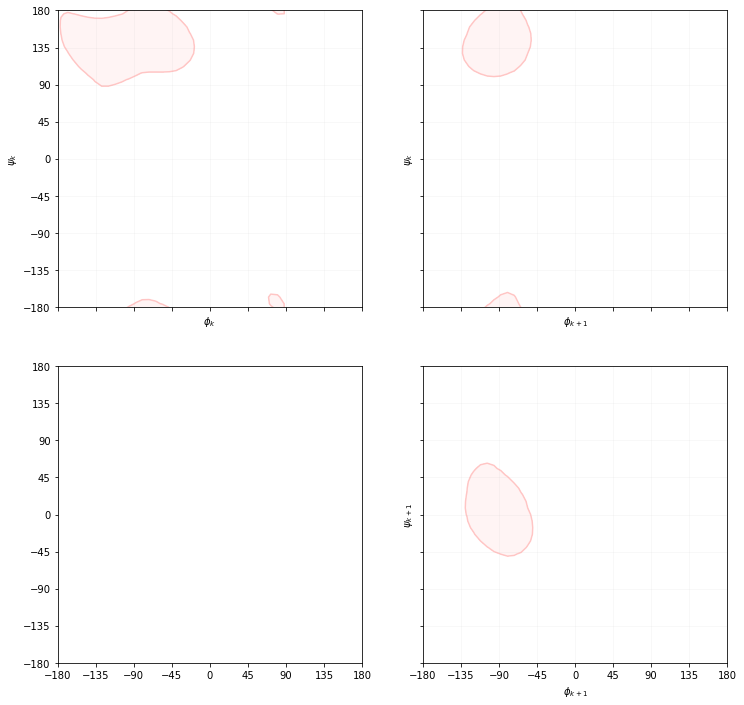

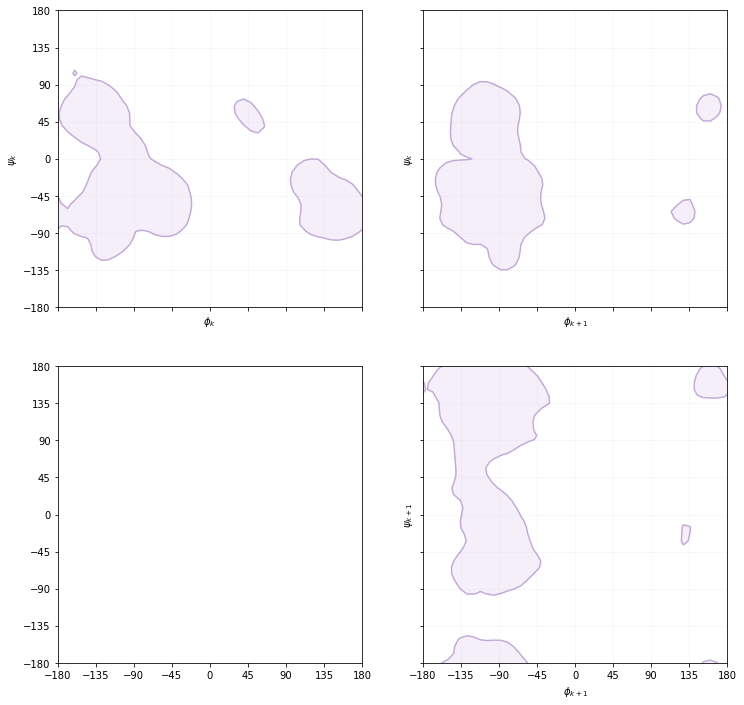

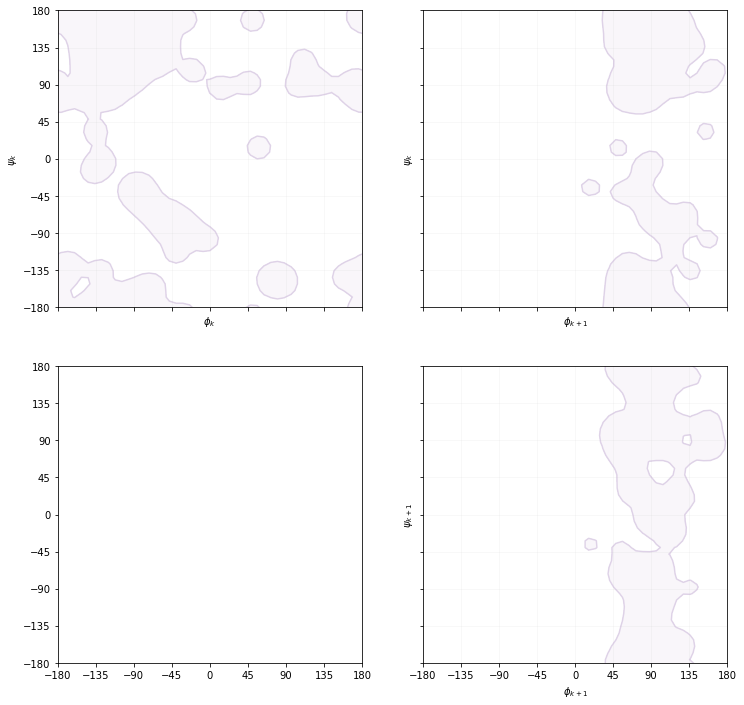

In [247]:
fig = plt.figure(figsize=(12,12))
axs = fig.subplots(2,2, sharey='all', sharex='all')
for n, l in enumerate(sortorder):
    fig = plt.figure(figsize=(12,12))
    axs = fig.subplots(2,2, sharey='all', sharex='all')
    idx = (labels==l)
    c = Cangles_nrm[idx,:]
    involved_labels = set(np.array([*range(0,Pnrm.shape[0])])[idx])
    idx_all = np.array([k for k, label in enumerate(all_labels) if label in involved_labels ])
    idx_all = np.random.permutation(idx_all)
    idx_all = idx_all[0:15000]
    print(f'{n}\t{l}\t{idx.sum()}\t{len(idx_all)}')
    #fig = plt.figure(figsize=(12,12))
    #axs = fig.subplots(2,2, sharey='all', sharex='all')
    
    plt.sca(axs[0,0])
    #axs[0,0].plot(all_angles[idx_all,0], all_angles[idx_all,1], 'o', color=colors[n], markersize=.5, alpha=0.12)
    contour(all_angles[:,[0,1]][idx_all,:]*np.pi/180., col=colors[n], alphaout=.5, alphain=0.1, bin_width=8*np.pi/180.)
    #axs[0,0].plot(c[:,0], c[:,1], 'o', color=colors[n], markersize=1)
    axs[0,0].set_xlabel('$\phi_k$')
    axs[0,0].set_ylabel('$\psi_k$')
    
    plt.sca(axs[0,1])
    #axs[0,1].plot(all_angles[idx_all,2], all_angles[idx_all,1], 'o', color=colors[n], markersize=.5, alpha=0.12)
    contour(all_angles[:,[2,1]][idx_all,:]*np.pi/180., col=colors[n], alphaout=.5, alphain=0.1, bin_width=8*np.pi/180.)
    #axs[0,1].plot(c[:,2], c[:,1], 'o', color=colors[n], markersize=1)
    axs[0,1].set_xlabel('$\phi_{k+1}$')
    axs[0,1].set_ylabel('$\psi_k$')
    
    plt.sca(axs[1,1])
    #axs[1,1].plot(all_angles[idx_all,2], all_angles[idx_all,3], 'o', color=colors[n], markersize=.5, alpha=0.12)
    contour(all_angles[:,[2,3]][idx_all,:]*np.pi/180., col=colors[n], alphaout=.5, alphain=0.1, bin_width=8*np.pi/180.)
    #axs[1,1].plot(c[:,2], c[:,3], 'o', color=colors[n], markersize=1)
    axs[1,1].set_xlabel('$\phi_{k+1}$')
    axs[1,1].set_ylabel('$\psi_{k+1}$')
    
    for ax in [axs[0,0], axs[0,1], axs[1,1]]:
        ax.set_xticks([-180,-135,-90,-45,0,45,90,135,180])
        ax.set_yticks([-180,-135,-90,-45,0,45,90,135,180])
        ax.set_xlim([-180,180])
        ax.set_ylim([-180,180])
        ax.grid(alpha=0.1)

In [ ]:
with open(f'dynclusters-{K//1000}K-{k}.pkl', 'wb') as f:
    pickle.dump({
        'Cnrm': Cnrm,
        'Cangles_nrm': Cangles_nrm,
        'labels': labels,
        'all_labels': all_labels,
        'all_angles': all_angles,
    }, f)

In [ ]:
np.array(clusters['rms']).std()